In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [39]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [40]:
# combining the train and test dataset, without the 'SalePrice' and 'Id' columns now
# so as to not interfere when separating for X_train, X_test, and y

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Looking at the distrbution of the SalePrice, and a ln(x+1) transformation on SalePrice.

- ln(x+1) is used just in case there are any discontinuities or any values at 0, it will not break the code.

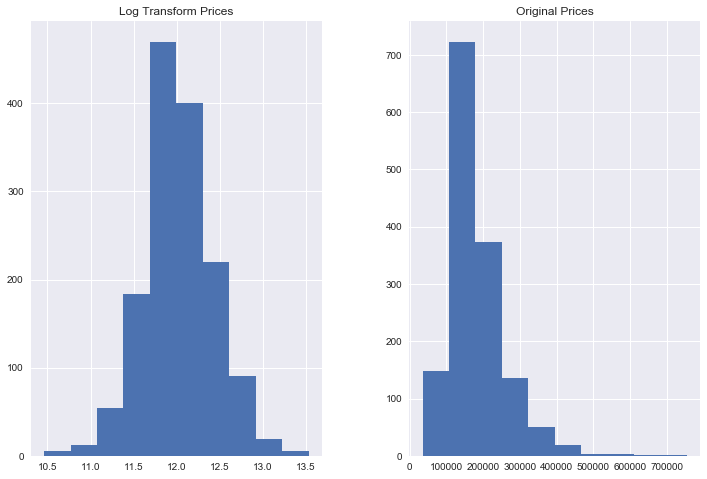

In [41]:
prices = pd.DataFrame({"Original Prices":train["SalePrice"],
                       "Log Transform Prices":np.log1p(train["SalePrice"])})

prices.hist()
plt.show()

In [42]:
print('The skewness value for regular SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for regular SalePrice is: 1.880940746034036


In [43]:
# transforming the saleprice variable
train["SalePrice"] = np.log1p(train["SalePrice"])

# the new skewness value
print('The skewness value for the transformed SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for the transformed SalePrice is: 0.12122191311528359


In [44]:
num_feats = all_data.dtypes[all_data.dtypes != 'object'].index
all_data[num_feats].isna().sum().sort_values(ascending=False).head(15)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
OverallCond       0
YearBuilt         0
YearRemodAdd      0
OverallQual       0
dtype: int64

Since it doesn't make sense to impute the `LotFrontage` or `GarageYrBlt` with a value of 0, we can either impute it with the mean or median of that column. Or use KNN (probably the best solution). 

Doing the safe route for now, by imputing the missing values with the median of the column.

In [45]:
all_data.LotFrontage = all_data.LotFrontage.fillna(all_data.LotFrontage.median())
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data.GarageYrBlt.median())

Filling in the rest of the missing variables (mostly categorical at this point) with 0.

In [46]:
all_data = all_data.fillna(0)

Applying the log transform to all the features that have a skewness value above 0.75:

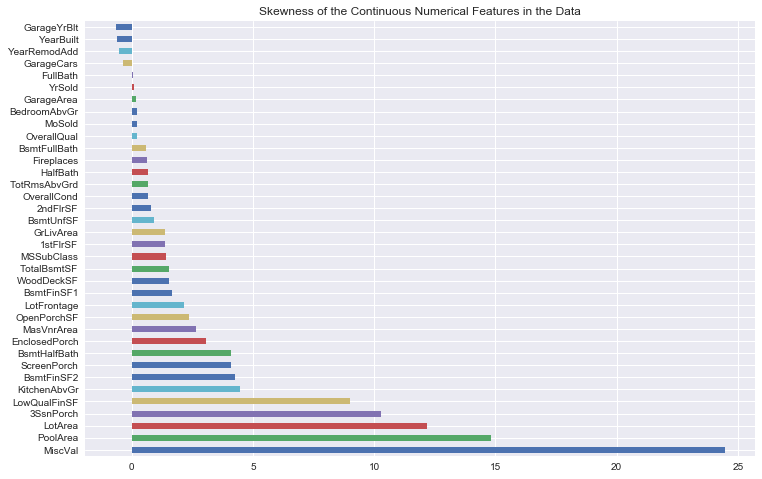

In [47]:
skewed_feat_vals = train[num_feats].apply(lambda x: skew(x.dropna()))
skewed_feat_vals = skewed_feat_vals.sort_values(ascending=False)

skewed_feat_vals.plot(kind = "barh")
plt.title("Skewness of the Continuous Numerical Features in the Data")
plt.show()

Log transforming any features that have a skewness of above 0.75:

In [49]:
skewed_feats = skewed_feat_vals[skewed_feat_vals > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Transforming any categorical columns with strings into dummy columns (so it is either 0 or 1 depending on what category the observation falls into). 

In [51]:
all_data = pd.get_dummies(all_data, drop_first=True)
print('Dimensions of the final dataset: ' + str(all_data.shape))

Dimensions of the final dataset: (2919, 268)


Setting the `X_train`, `X_test`, and `y` variables for use with the Lasso Regularization model in sklearn. 

In [52]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [53]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# Defining a RMSE function to calculate the residual mean squared error to evaluate the model
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [55]:
alpha_vals = np.logspace(-4, 4, 1000)

model_lasso_LOO = LassoCV(alphas = alpha_vals, normalize=True).fit(X_train, y) 
print("Best alpha value: " + str(model_lasso_LOO.alpha_))
print("Corresponding R^2 score: " + str(model_lasso_LOO.score(X_train, y)))

Best alpha value: 0.00011377741332214914
Corresponding R^2 score: 0.9251423114391033


In [56]:
alpha_vals = np.logspace(-4, 4, 1000)

model_lasso_5CV = LassoCV(alphas = alpha_vals, normalize=True, cv=5).fit(X_train, y) 
print("Best alpha value: " + str(model_lasso_5CV.alpha_))
print("Corresponding R^2 score: " + str(model_lasso_5CV.score(X_train, y)))

Best alpha value: 0.00011805165285688056
Corresponding R^2 score: 0.9245915437714944


In [57]:
print("Model using LOO CV for training:")
print("With 5-fold CV, the RMSE values are: " + str(rmse_cv(model_lasso_LOO, X_train, y)))
print("Average RMSE: " + str(rmse_cv(model_lasso_LOO, X_train, y).mean()))
print("-" * 50)
print("Model using 5-fold CV for training:")
print("With 5-fold CV, the RMSE values are: " + str(rmse_cv(model_lasso_5CV, X_train, y)))
print("Average RMSE: " + str(rmse_cv(model_lasso_5CV, X_train, y).mean()))

Model using LOO CV for training:
With 5-fold CV, the RMSE values are: [0.10243    0.13288816 0.13626522 0.11244549 0.14560481]
Average RMSE: 0.12592673694633943
--------------------------------------------------
Model using 5-fold CV for training:
With 5-fold CV, the RMSE values are: [0.10266714 0.13279369 0.13595896 0.11224452 0.14571073]
Average RMSE: 0.1258750079858471


Looking through the coefficients that were kept/eliminated and which ones were deemed important:

In [58]:
beta_vals = pd.Series(model_lasso_5CV.coef_, index = X_train.columns)

print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 92
Variables eliminated: 176


In [59]:
print(beta_vals.sort_values().head(10))
print(beta_vals.sort_values().tail(10))

important_feat = pd.concat([beta_vals.sort_values().head(10), beta_vals.sort_values().tail(10)])

Condition2_PosN        -0.451788
MSZoning_C (all)       -0.333829
PoolQC_Gd              -0.221775
Functional_Sev         -0.188207
Functional_Maj2        -0.150032
KitchenAbvGr           -0.132030
Exterior1st_BrkComm    -0.100066
Heating_Grav           -0.093415
LotShape_IR3           -0.051125
Neighborhood_Edwards   -0.048406
dtype: float64
GarageQual_Ex           0.060534
SaleType_New            0.061517
Neighborhood_NridgHt    0.070511
1stFlrSF                0.073287
LotArea                 0.074147
Neighborhood_NoRidge    0.082145
RoofMatl_WdShngl        0.089308
Neighborhood_Crawfor    0.097690
Neighborhood_StoneBr    0.099126
GrLivArea               0.376539
dtype: float64


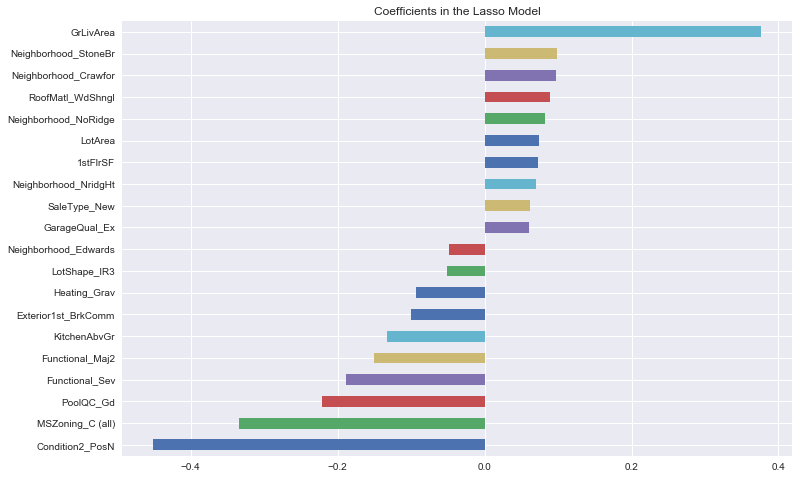

In [60]:
important_feat.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [63]:
pred = np.expm1(model_lasso_5CV.predict(X_test))

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
submission.to_csv('attempt_lasso_5cv.csv', index=False)

In [64]:
pred = np.expm1(model_lasso_LOO.predict(X_test))

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
submission.to_csv('attempt_lasso_LOO.csv', index=False)